In [12]:
# Install dependencies
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.0 MB 2.8 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.0 MB 2.8 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.0 MB 2.6 MB/s eta 0:00:03
   ------------- -------------------------- 2.6/8.0 MB 3.0 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.0 MB 3.0 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.0 MB 3.0 MB/s eta 0:00:02
   ---------------------- ----------------- 4.5/8.0 MB 3.0 MB/s eta 0:00:02
   -------------------------- ------------- 5.2/8.0 MB 3.1 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.0 MB 3.1 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.0 MB 3.1 MB/s eta 0:00:01
   ------------------------------------

In [13]:
# Import dependencies
import pandas as pd

# Import data
bankdata = pd.read_csv("bank_transactions_data_2.csv")

bankdata.info()
bankdata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


In [ ]:
# Clean features


In [ ]:
# Feature extraction / data visualisation

In [50]:
# Labelling
'''
I'll apply these rules to label transactions as fraudulent (1) or normal (0) based on:

Unusual Transaction Amounts – Transactions that are in the top 1% or bottom 1% of amounts.
Unusual Locations or Devices – Transactions from a location/device that is unique in the dataset.
High Login Attempts – Transactions with LoginAttempts > 3.
Short Transaction Duration – Transactions completed in less than 5 seconds.
Mismatch in Transaction Patterns – Large online transactions (above 90th percentile).
'''

df = pd.read_csv("bank_transactions_labeled.csv")
df.info()

from sklearn.ensemble import IsolationForest

# Feature Engineering: Create 'TimeSinceLastTransaction'
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"])
df["TimeSinceLastTransaction"] = (df["TransactionDate"] - df["PreviousTransactionDate"]).dt.total_seconds()
df.drop(["TransactionDate", "PreviousTransactionDate"], axis=1, inplace=True)

# Convert categorical columns to numeric using Label Encoding
from sklearn.preprocessing import LabelEncoder
categorical_cols = ["TransactionType", "Channel", "Location", "DeviceID", "IP Address", "MerchantID"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Select enhanced feature set
features = ["TransactionAmount", "LoginAttempts", "AccountBalance", "TransactionDuration", 
            "TimeSinceLastTransaction", "CustomerAge", "TransactionType", "Channel", "Location"]

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df["Fraud_IF"] = iso_forest.fit_predict(df[features])

# Convert -1 (fraud) and 1 (normal) to 1 (fraud) and 0 (normal)
df["Fraud_IF"] = df["Fraud_IF"].map({1: 0, -1: 1})

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Reduce `nu` to lower fraud detection rate
ocsvm = OneClassSVM(kernel="rbf", nu=0.1, gamma="scale")  # nu was reduced from 0.1 to 0.01
df["Fraud_OCSVM"] = ocsvm.fit_predict(X_scaled)

# Convert labels: -1 is fraud, 1 is normal
df["Fraud_OCSVM"] = df["Fraud_OCSVM"].apply(lambda x: 1 if x == -1 else 0)

# Print fraud count after tuning
print(df["Fraud_OCSVM"].value_counts())

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Increase `eps` to make DBSCAN less sensitive
dbscan = DBSCAN(eps=1.85, min_samples=20)  # Increased values to reduce noise
df["Fraud_DBSCAN"] = dbscan.fit_predict(X_scaled)

# Label outliers (-1) as fraud
df["Fraud_DBSCAN"] = df["Fraud_DBSCAN"].apply(lambda x: 1 if x == -1 else 0)
print(df["Fraud_DBSCAN"].value_counts())  # Check fraud count

# df["Fraud_Heuristic"] = 0  # Default non-fraud

# # Rule 1: Top 0.5% high-value transactions instead of top 1%
# df.loc[df["TransactionAmount"] > df["TransactionAmount"].quantile(0.995), "Fraud_Heuristic"] = 1

# # Rule 2: Increase login attempts threshold to >15
# df.loc[df["LoginAttempts"] > 15, "Fraud_Heuristic"] = 1

# # Rule 3: Only flag if account balance is negative by more than $500
# df.loc[df["AccountBalance"] - df["TransactionAmount"] < -500, "Fraud_Heuristic"] = 1

# # Rule 4: Rare device or IP detected in <0.2% of transactions
# rare_devices = df["DeviceID"].value_counts()[df["DeviceID"].value_counts() < df.shape[0] * 0.002].index
# df.loc[df["DeviceID"].isin(rare_devices), "Fraud_Heuristic"] = 1

# print(df[["Fraud_IF", "Fraud_OCSVM", "Fraud_DBSCAN", "Fraud_Heuristic"]].sum())
print(df[["FraudLabel","Fraud_IF", "Fraud_OCSVM", "Fraud_DBSCAN"]].sum())

SyntaxError: unterminated string literal (detected at line 3) (901741132.py, line 3)

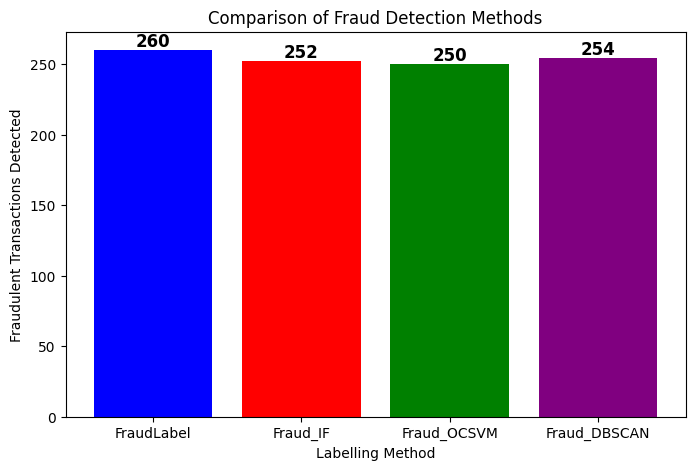

At least 2 methods
     TransactionID AccountID  TransactionAmount  TransactionType  Location  \
26        TX000027   AC00441             246.93                1        24   
85        TX000086   AC00098            1340.19                0         2   
147       TX000148   AC00161             514.95                1        27   
190       TX000191   AC00396            1422.55                1        42   
266       TX000267   AC00178              66.90                0         5   
...            ...       ...                ...              ...       ...   
2288      TX002289   AC00149             336.01                1         7   
2310      TX002311   AC00243             176.52                0        36   
2380      TX002381   AC00098            1173.74                0        41   
2403      TX002404   AC00111            1493.00                1         7   
2423      TX002424   AC00340             332.06                1        39   

      DeviceID  IP Address  MerchantID  Chan

PermissionError: [Errno 13] Permission denied: 'fraud_detection_results.csv'

In [49]:
import matplotlib.pyplot as plt

# Compare Fraud Detection Counts
methods = ["FraudLabel", "Fraud_IF", "Fraud_OCSVM", "Fraud_DBSCAN"]
fraud_counts = [df[m].sum() for m in methods]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, fraud_counts, color=['blue', 'red', 'green', 'purple'])

# Add number labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(yval), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Labelling Method")
plt.ylabel("Fraudulent Transactions Detected")
plt.title("Comparison of Fraud Detection Methods")

plt.show()

# Compare Agreement Between Methods
df["Total_Fraud_Detections"] = df[["FraudLabel", "Fraud_IF", "Fraud_OCSVM", "Fraud_DBSCAN"]].sum(axis=1)

# Show transactions detected by multiple methods
print("At least 2 methods")
print(df[df["Total_Fraud_Detections"] >= 4])  # Detected by at least 2 methods

df.to_csv("fraud_detection_results.csv", index=False)


In [ ]:
# Split data (training, development, test)

In [9]:
# Gradient Boosting Classification
# Import models and utility functions
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits

# Setting SEED for reproducibility
SEED = 23

# Importing the dataset
X, y = load_digits(return_X_y=True)

# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, y,
													test_size = 0.25,
													random_state = SEED)

# Instantiate Gradient Boosting Regressor
gbc = GradientBoostingClassifier(n_estimators=300,
								learning_rate=0.05,
								random_state=100,
								max_features=5 )
# Fit to training set
gbc.fit(train_X, train_y)

# Predict on test set
pred_y = gbc.predict(test_X)

# accuracy
acc = accuracy_score(test_y, pred_y)
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(acc))


Gradient Boosting Classifier accuracy is : 0.98


In [ ]:
# Gradient Boosting Regression
# Import the necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes

# Setting SEED for reproducibility
SEED = 23

# Importing the dataset 
X, y = load_diabetes(return_X_y=True)

# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, y, 
													test_size = 0.25, 
													random_state = SEED)

# Instantiate Gradient Boosting Regressor
gbr = GradientBoostingRegressor(loss='absolute_error',
								learning_rate=0.1,
								n_estimators=300,
								max_depth = 1, 
								random_state = SEED,
								max_features = 5)

# Fit to training set
gbr.fit(train_X, train_y)

# Predict on test set
pred_y = gbr.predict(test_X)

# test set RMSE
test_rmse = mean_squared_error(test_y, pred_y) ** (1 / 2)

# Print rmse
print('Root mean Square error: {:.2f}'.format(test_rmse))
